# Predict Fix Page Duration
Inputs:
- timestamp
- duration_ms
- function_name
- page_num
- exclusive
- pool_size
- fifo_size
- lru_size

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
data_path = './buffer_stats.csv'
df = pd.read_csv(data_path)
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,400000.0,NaN,NaN,NaN,1731702690.776222,7.159491,1731702678.0,1731702685.0,1731702691.0,1731702697.0,1731702703.0
duration_ms,400000.0,NaN,NaN,NaN,0.201867,0.325946,0.002,0.161,0.211,0.218,79.157
function_name,400000,1,fix_page,400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
page_num,400000.0,NaN,NaN,NaN,50.019742,29.138978,0.0,25.0,50.0,75.0,100.0
exclusive,400000,1,shared,400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pool_size,400000.0,NaN,NaN,NaN,10.0,0.0,10.0,10.0,10.0,10.0,10.0
fifo_size,400000.0,NaN,NaN,NaN,2.269382,0.542924,0.0,2.0,2.0,3.0,10.0
lru_size,400000.0,NaN,NaN,NaN,7.7239,0.538451,0.0,7.0,8.0,8.0,10.0
locking,400000.0,NaN,NaN,NaN,0.141879,0.277485,0.0,0.101,0.151,0.156,79.036
queues,400000.0,NaN,NaN,NaN,0.000144,0.008553,0.0,0.0,0.0,0.0,5.28


In [7]:
# Naive MSE
df['avg_duration'] = df['duration_ms'].mean()
mse = mean_squared_error(df['duration_ms'], df['avg_duration'])
abse = mean_absolute_error(df['duration_ms'], df['avg_duration'])

(array([3.99754e+05, 1.08000e+02, 5.90000e+01, 2.70000e+01, 1.30000e+01,
        1.20000e+01, 6.00000e+00, 4.00000e+00, 4.00000e+00, 5.00000e+00,
        1.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([2.00000e-03, 2.64050e+00, 5.27900e+00, 7.91750e+00, 1.05560e+01,
        1.31945e+01, 1.58330e+01, 1.84715e+01, 2.11100e+01, 2.37485e+01,
        2.63870e+01, 2.90255e+01, 3.16640e+01, 3.43025e+01, 3.69410e+01,
        3.95795e+01, 4.22180e+01, 4.48565e+01, 4.74950e+01, 5.01335e+01,
        5.27720e+01, 5.54105e+01, 5.80490e+01, 6.06875e+01, 6.33260e+01,
        6.59645e+01, 6.86030e+01, 7.12415e+01, 7.38800e+01, 7.65185e+01,
        7.91570e+01]),
 <BarContainer object of 30 artists>)

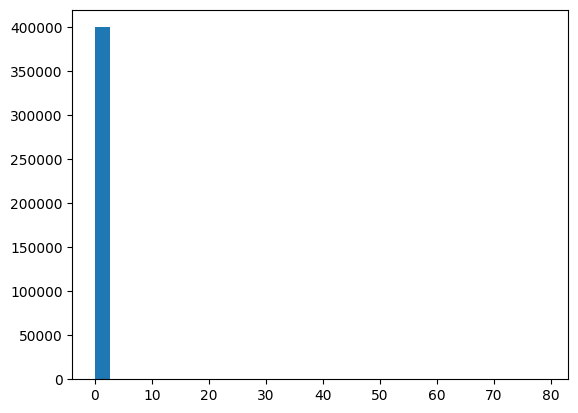

In [8]:
# Bin by duration
bins = [0,0.15, 0.3, 1, 5, 40]
df['duration_bins'] = pd.cut(df['duration_ms'], bins=bins)
df['duration_bins'].value_counts()
plt.hist(df['duration_ms'], bins=30)

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


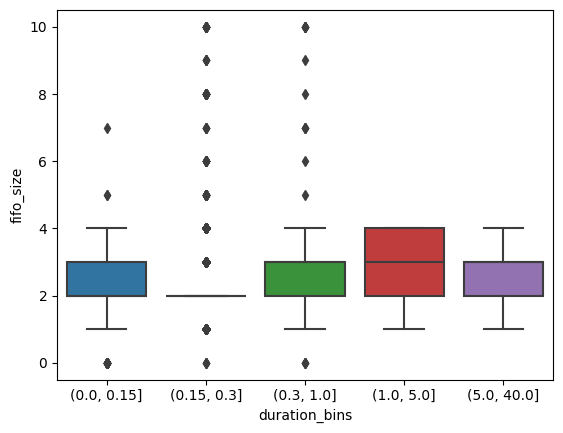

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='duration_bins', ylabel='lru_size'>

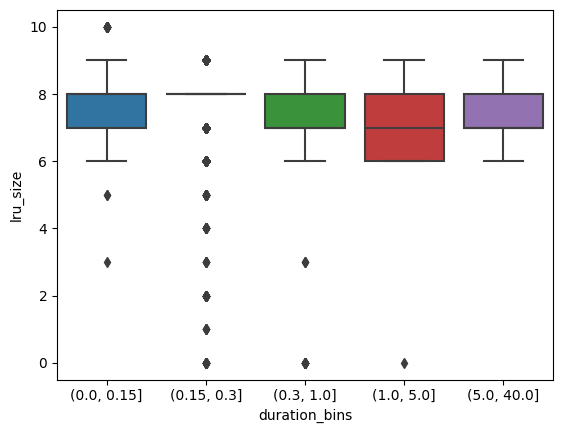

In [9]:
# Is fifo size or lru size predictive?
sns.boxplot(data=df, x='duration_bins', y='fifo_size')
plt.show()
sns.boxplot(data=df, x='duration_bins', y='lru_size')

<Axes: xlabel='duration_ms', ylabel='Count'>

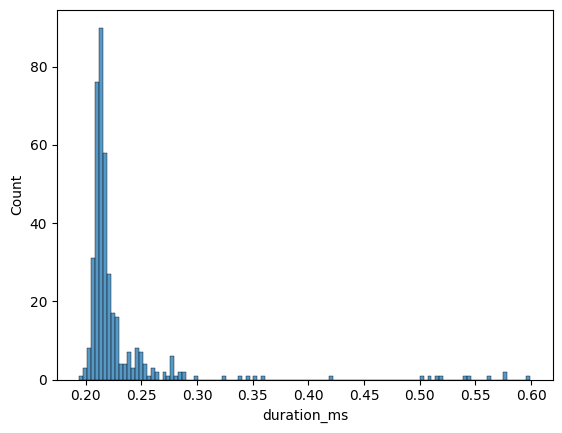

In [ ]:
# By page num
page_num_durations = df.groupby(by='page_num')['duration_ms'].mean()
sns.histplot(page_num_durations)

In [ ]:
# How long ago the same page was accessed
first_access = df.groupby(by='page_num').apply(lambda x : x.index[0])
df['First Access'] = df.apply(lambda x: x.index == first_access[x['page_num']], axis=0)
df.head()